In [58]:


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random



In [73]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])


In [74]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [75]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

1.7877501
0.00028320498
0.00015533464
0.00014431357
0.00013644386
0.00038424335


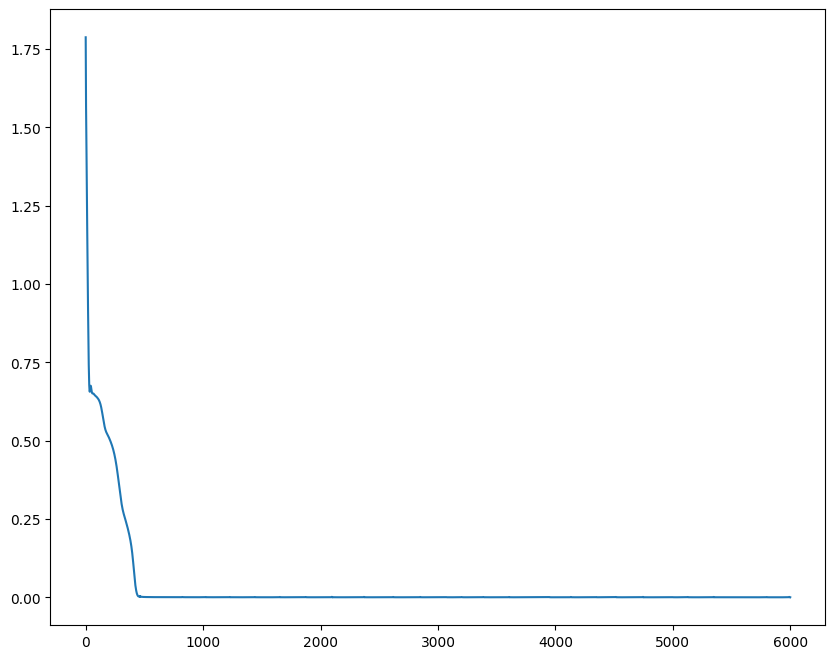

In [76]:
train_t = (np.array([0., 0.025, 0.05,0.1,0.25, 0.475, 0.5, 0.525, 0.9, 0.95, 1., 1.05, 1.1,1.25,1.3,1.35, 1.4, 1.45, 1.5, 1.55, 1.6,1.75, 1.95, 2.])).reshape(-1, 1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


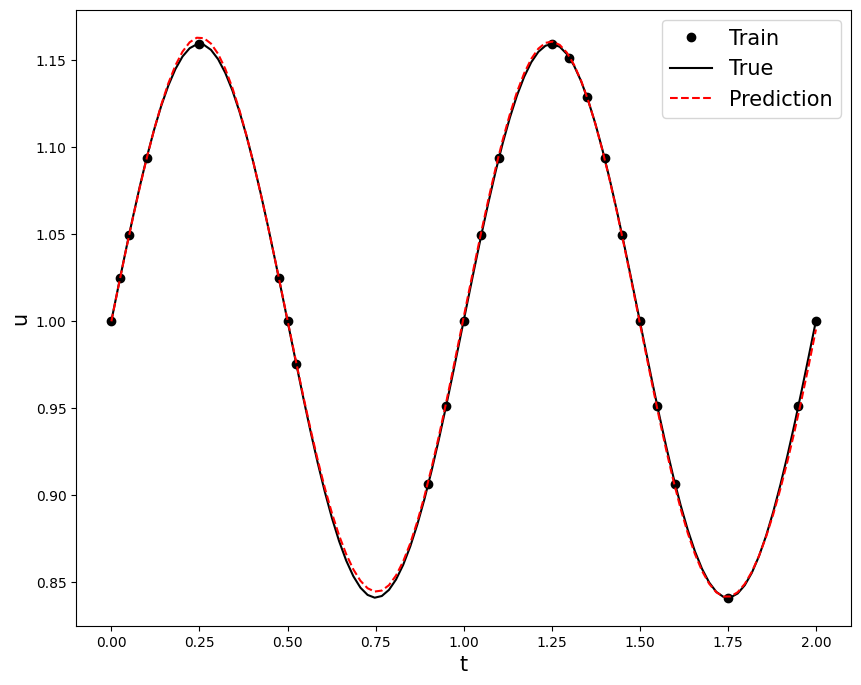

In [77]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

In [15]:
import tensorflow as tf
import numpy as np

# Définir l'architecture du réseau
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='tanh', input_shape=(1,)),  # Input shape corresponds to spatial dimension (1D here)
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(2)  # Outputs (displacement u and stress σ)
])


In [16]:
# Générer des points d'entraînement
x_train = np.linspace(0, 1, 100)[:, None]  # 100 points dans la plage [0, 1]
u_train = np.sin(np.pi * x_train)  # Déplacements hypothétiques
σ_train = np.pi * np.cos(np.pi * x_train)  # Contraintes hypothétiques dérivées des déplacements

# Combiner les données de sortie
y_train = np.hstack((u_train, σ_train))

# Convertir les données en tenseurs TensorFlow
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)


In [17]:
def compute_pde_loss(gradients):
    # Placeholder pour le calcul de la perte des PDE
    # Utiliser les gradients pour vérifier l'équilibre des forces, par exemple
    return tf.reduce_mean(tf.square(gradients))

def compute_bc_loss(predictions, bc_values):
    # Calcul de la perte des conditions aux limites
    return tf.reduce_mean(tf.square(predictions - bc_values))


In [20]:
# Définir les valeurs de conditions aux limites
bc_values = np.array([[0.0, 0.0], [0.0, 0.0]], dtype=np.float32)  # Par exemple, zéro déplacement et contrainte aux limites
bc_values_tf = tf.convert_to_tensor(bc_values, dtype=tf.float32)

# Sélectionner les points de la frontière
x_bc = tf.convert_to_tensor([x_train[0], x_train[-1]], dtype=tf.float32)
y_bc = tf.convert_to_tensor([y_train[0], y_train[-1]], dtype=tf.float32)

def loss(model, x, y_true):
    y_pred = model(x)
    loss_data = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Calculer les gradients pour les PDEs
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        gradients = tape.gradient(y_pred, x)
    
    loss_pde = compute_pde_loss(gradients)
    
    # Appliquer les conditions aux limites uniquement aux points de la frontière
    y_bc_pred = model(x_bc)
    loss_bc = compute_bc_loss(y_bc_pred, y_bc)
    
    return loss_data + 1.0 * loss_pde + 1.0 * loss_bc  # Pondération des termes de perte


In [21]:
# Optimiseur
optimizer = tf.keras.optimizers.Adam()

# Entraînement
num_epochs = 1000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_train_tf, y_train_tf)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")


Epoch 0: Loss = 7.707766532897949
Epoch 100: Loss = 3.6050381660461426
Epoch 200: Loss = 3.6001808643341064
Epoch 300: Loss = 3.5946526527404785
Epoch 400: Loss = 3.5848188400268555
Epoch 500: Loss = 3.568075656890869
Epoch 600: Loss = 3.5487470626831055
Epoch 700: Loss = 3.5389537811279297
Epoch 800: Loss = 3.5347280502319336
Epoch 900: Loss = 3.5307958126068115


Epoch 0: Loss = 7.599910736083984
Epoch 100: Loss = 3.6031460762023926
Epoch 200: Loss = 3.598149299621582
Epoch 300: Loss = 3.5902724266052246
Epoch 400: Loss = 3.575894355773926
Epoch 500: Loss = 3.556039810180664
Epoch 600: Loss = 3.5409996509552
Epoch 700: Loss = 3.534451961517334
Epoch 800: Loss = 3.5303497314453125
Epoch 900: Loss = 3.5258536338806152
Epoch 1000: Loss = 3.5202507972717285
Epoch 1100: Loss = 3.512988567352295
Epoch 1200: Loss = 3.5051560401916504
Epoch 1300: Loss = 3.500389575958252
Epoch 1400: Loss = 3.498969078063965
Epoch 1500: Loss = 3.4986324310302734
Epoch 1600: Loss = 3.4984583854675293
Epoch 1700: Loss = 3.498302698135376
Epoch 1800: Loss = 3.498152732849121
Epoch 1900: Loss = 3.4980075359344482
Epoch 2000: Loss = 3.497866630554199
Epoch 2100: Loss = 3.4977293014526367
Epoch 2200: Loss = 3.49759578704834
Epoch 2300: Loss = 3.4974987506866455
Epoch 2400: Loss = 3.497344970703125
Epoch 2500: Loss = 3.4972336292266846
Epoch 2600: Loss = 3.497128963470459
Epoc

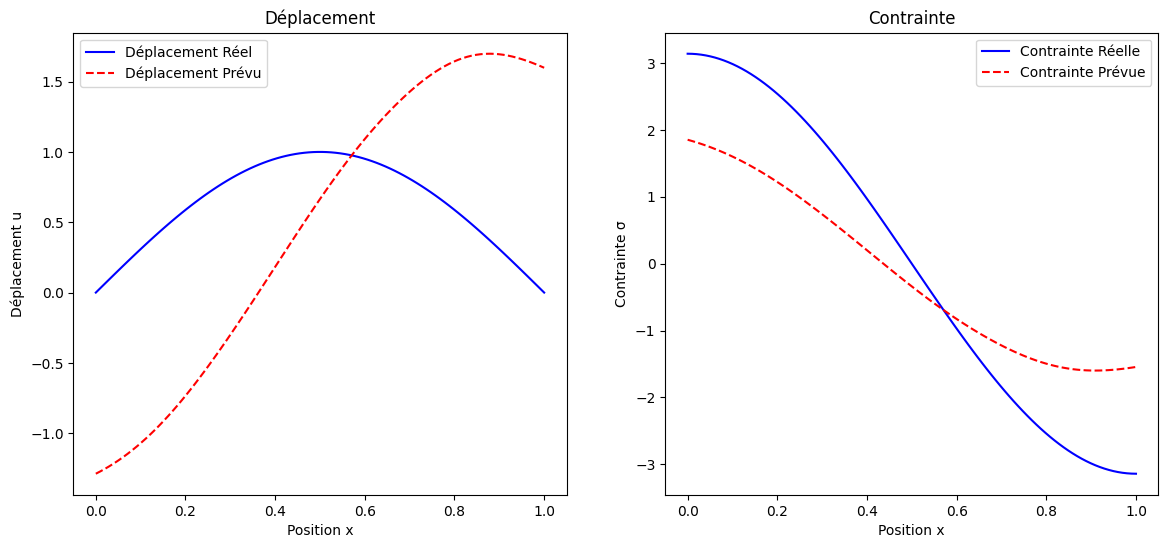

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Définir l'architecture du réseau
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='tanh', input_shape=(1,)),  # Input shape corresponds to spatial dimension (1D here)
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(2)  # Outputs (displacement u and stress σ)
])

# Générer des points d'entraînement
x_train = np.linspace(0, 1, 100)[:, None]  # 100 points dans la plage [0, 1]
u_train = np.sin(np.pi * x_train)  # Déplacements hypothétiques
σ_train = np.pi * np.cos(np.pi * x_train)  # Contraintes hypothétiques dérivées des déplacements

# Combiner les données de sortie
y_train = np.hstack((u_train, σ_train))

# Convertir les données en tenseurs TensorFlow
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

def compute_pde_loss(gradients):
    # Placeholder pour le calcul de la perte des PDE
    # Utiliser les gradients pour vérifier l'équilibre des forces, par exemple
    return tf.reduce_mean(tf.square(gradients))

def compute_bc_loss(predictions, bc_values):
    # Calcul de la perte des conditions aux limites
    return tf.reduce_mean(tf.square(predictions - bc_values))

# Définir les valeurs de conditions aux limites
bc_values = np.array([[0.0, 0.0], [0.0, 0.0]], dtype=np.float32)  # Par exemple, zéro déplacement et contrainte aux limites
bc_values_tf = tf.convert_to_tensor(bc_values, dtype=tf.float32)

# Sélectionner les points de la frontière
x_bc = tf.convert_to_tensor([x_train[0], x_train[-1]], dtype=tf.float32)
y_bc = tf.convert_to_tensor([y_train[0], y_train[-1]], dtype=tf.float32)

def loss(model, x, y_true):
    y_pred = model(x)
    loss_data = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Calculer les gradients pour les PDEs
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        gradients = tape.gradient(y_pred, x)
    
    loss_pde = compute_pde_loss(gradients)
    
    # Appliquer les conditions aux limites uniquement aux points de la frontière
    y_bc_pred = model(x_bc)
    loss_bc = compute_bc_loss(y_bc_pred, y_bc)
    
    return loss_data + 1.0 * loss_pde + 1.0 * loss_bc  # Pondération des termes de perte

# Optimiseur
optimizer = tf.keras.optimizers.Adam()

# Entraînement
num_epochs = 10000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_train_tf, y_train_tf)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
y_pred = model(x_train_tf)

# Conversion des prédictions en numpy arrays pour la visualisation
y_pred_np = y_pred.numpy()

# Visualisation des résultats
plt.figure(figsize=(14, 6))

# Plot des déplacements
plt.subplot(1, 2, 1)
plt.plot(x_train, u_train, 'b-', label='Déplacement Réel')
plt.plot(x_train, y_pred_np[:, 0], 'r--', label='Déplacement Prévu')
plt.xlabel('Position x')
plt.ylabel('Déplacement u')
plt.legend()
plt.title('Déplacement')

# Plot des contraintes
plt.subplot(1, 2, 2)
plt.plot(x_train, σ_train, 'b-', label='Contrainte Réelle')
plt.plot(x_train, y_pred_np[:, 1], 'r--', label='Contrainte Prévue')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte')

plt.show()


Epoch 0: Loss = 3.8498754501342773
Epoch 100: Loss = 1.1980290412902832
Epoch 200: Loss = 1.177229881286621
Epoch 300: Loss = 1.1715154647827148
Epoch 400: Loss = 1.1708011627197266
Epoch 500: Loss = 1.1705784797668457
Epoch 600: Loss = 1.1704288721084595
Epoch 700: Loss = 1.170310378074646
Epoch 800: Loss = 1.1709932088851929
Epoch 900: Loss = 1.17013418674469
Epoch 1000: Loss = 1.1700570583343506
Epoch 1100: Loss = 1.1699891090393066
Epoch 1200: Loss = 1.1699151992797852
Epoch 1300: Loss = 1.1698336601257324
Epoch 1400: Loss = 1.1697558164596558
Epoch 1500: Loss = 1.1696513891220093
Epoch 1600: Loss = 1.1695257425308228
Epoch 1700: Loss = 1.1694245338439941
Epoch 1800: Loss = 1.1692984104156494
Epoch 1900: Loss = 1.1692067384719849
Epoch 2000: Loss = 1.1692770719528198
Epoch 2100: Loss = 1.1691293716430664
Epoch 2200: Loss = 1.1691118478775024
Epoch 2300: Loss = 1.1691033840179443
Epoch 2400: Loss = 1.1691097021102905
Epoch 2500: Loss = 1.1690980195999146
Epoch 2600: Loss = 1.1690952

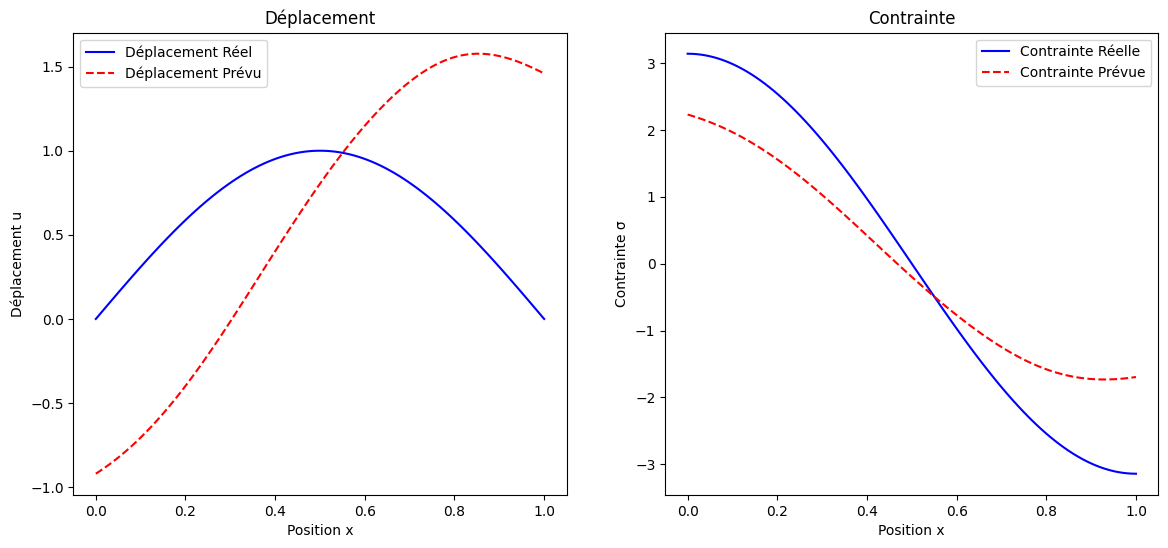

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Définir l'architecture du réseau avec plus de couches et de neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='tanh', input_shape=(1,)),  # Input shape corresponds to spatial dimension (1D here)
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(2)  # Outputs (displacement u and stress σ)
])

# Générer des points d'entraînement
x_train = np.linspace(0, 1, 100)[:, None]  # 100 points dans la plage [0, 1]
u_train = np.sin(np.pi * x_train)  # Déplacements hypothétiques
σ_train = np.pi * np.cos(np.pi * x_train)  # Contraintes hypothétiques dérivées des déplacements

# Combiner les données de sortie
y_train = np.hstack((u_train, σ_train))

# Convertir les données en tenseurs TensorFlow
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

def compute_pde_loss(gradients):
    # Placeholder pour le calcul de la perte des PDE
    # Utiliser les gradients pour vérifier l'équilibre des forces, par exemple
    return tf.reduce_mean(tf.square(gradients))

def compute_bc_loss(predictions, bc_values):
    # Calcul de la perte des conditions aux limites
    return tf.reduce_mean(tf.square(predictions - bc_values))

# Définir les valeurs de conditions aux limites
bc_values = np.array([[0.0, 0.0], [0.0, 0.0]], dtype=np.float32)  # Par exemple, zéro déplacement et contrainte aux limites
bc_values_tf = tf.convert_to_tensor(bc_values, dtype=tf.float32)

# Sélectionner les points de la frontière
x_bc = tf.convert_to_tensor([x_train[0], x_train[-1]], dtype=tf.float32)
y_bc = tf.convert_to_tensor([y_train[0], y_train[-1]], dtype=tf.float32)

def loss(model, x, y_true):
    y_pred = model(x)
    loss_data = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Calculer les gradients pour les PDEs
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        gradients = tape.gradient(y_pred, x)
    
    loss_pde = compute_pde_loss(gradients)
    
    # Appliquer les conditions aux limites uniquement aux points de la frontière
    y_bc_pred = model(x_bc)
    loss_bc = compute_bc_loss(y_bc_pred, y_bc)
    
    return loss_data + 0.1 * loss_pde + 0.1 * loss_bc  # Pondération des termes de perte

# Optimiseur
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Entraînement
num_epochs = 5000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_train_tf, y_train_tf)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
y_pred = model(x_train_tf)

# Conversion des prédictions en numpy arrays pour la visualisation
y_pred_np = y_pred.numpy()

# Visualisation des résultats
plt.figure(figsize=(14, 6))

# Plot des déplacements
plt.subplot(1, 2, 1)
plt.plot(x_train, u_train, 'b-', label='Déplacement Réel')
plt.plot(x_train, y_pred_np[:, 0], 'r--', label='Déplacement Prévu')
plt.xlabel('Position x')
plt.ylabel('Déplacement u')
plt.legend()
plt.title('Déplacement')

# Plot des contraintes
plt.subplot(1, 2, 2)
plt.plot(x_train, σ_train, 'b-', label='Contrainte Réelle')
plt.plot(x_train, y_pred_np[:, 1], 'r--', label='Contrainte Prévue')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte')

plt.show()


Epoch 0: Loss = 5.572542190551758
Epoch 500: Loss = 0.04203305020928383
Epoch 1000: Loss = 0.04169882461428642
Epoch 1500: Loss = 0.041469257324934006
Epoch 2000: Loss = 0.04131000488996506
Epoch 2500: Loss = 0.041164372116327286
Epoch 3000: Loss = 0.04086850583553314
Epoch 3500: Loss = 0.040681906044483185
Epoch 4000: Loss = 0.04067892208695412
Epoch 4500: Loss = 0.04067756608128548
Epoch 5000: Loss = 0.04067470133304596
Epoch 5500: Loss = 0.04067240655422211
Epoch 6000: Loss = 0.04066866636276245
Epoch 6500: Loss = 0.04203411564230919
Epoch 7000: Loss = 0.040663789957761765
Epoch 7500: Loss = 0.040662795305252075
Epoch 8000: Loss = 0.04066292569041252
Epoch 8500: Loss = 0.04066333547234535
Epoch 9000: Loss = 0.04213801771402359
Epoch 9500: Loss = 0.041590310633182526


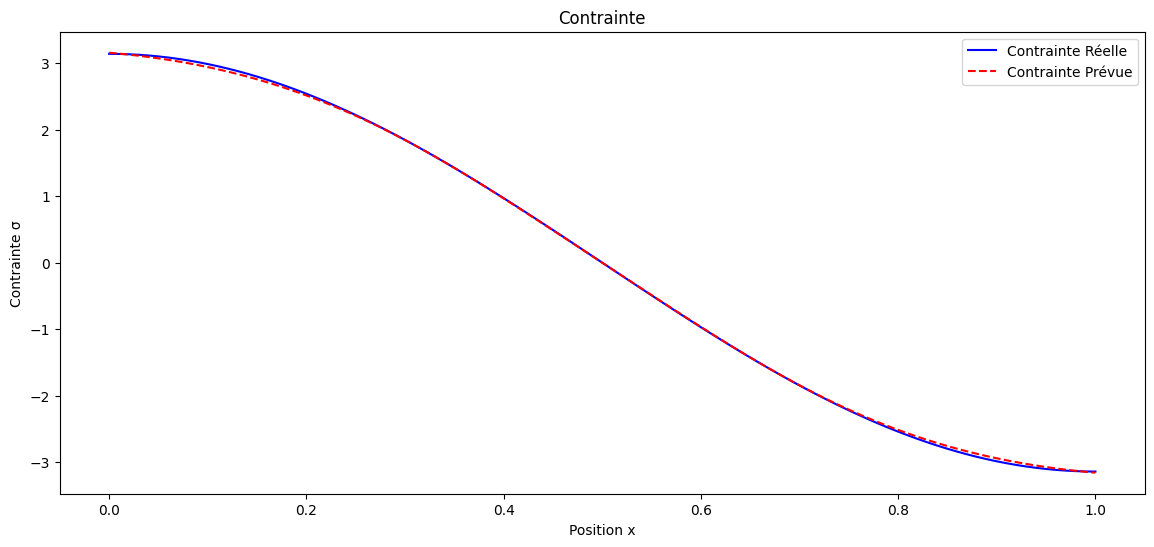

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Définir l'architecture du réseau avec plus de couches et de neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='tanh', input_shape=(1,)),  # Input shape corresponds to spatial dimension (1D here)
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(1)  # Output (stress σ)
])

# Générer des points d'entraînement
x_train = np.linspace(0, 1, 100)[:, None]  # 100 points dans la plage [0, 1]
σ_train = np.pi * np.cos(np.pi * x_train)  # Contraintes hypothétiques dérivées des déplacements

# Normaliser les données d'entrée
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_train = (x_train - x_train_mean) / x_train_std

# Convertir les données en tenseurs TensorFlow
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
σ_train_tf = tf.convert_to_tensor(σ_train, dtype=tf.float32)

def compute_pde_loss(gradients):
    return tf.reduce_mean(tf.square(gradients))

def compute_bc_loss(predictions, bc_values):
    return tf.reduce_mean(tf.square(predictions - bc_values))

# Définir les valeurs de conditions aux limites
bc_values = np.array([0.0, 0.0], dtype=np.float32)  # Par exemple, zéro contrainte aux limites
bc_values_tf = tf.convert_to_tensor(bc_values, dtype=tf.float32)

# Sélectionner les points de la frontière
x_bc = tf.convert_to_tensor([x_train[0], x_train[-1]], dtype=tf.float32)
σ_bc = tf.convert_to_tensor([σ_train[0], σ_train[-1]], dtype=tf.float32)

def loss(model, x, σ_true):
    σ_pred = model(x)
    loss_data = tf.reduce_mean(tf.square(σ_true - σ_pred))
    
    # Calculer les gradients pour les PDEs
    with tf.GradientTape() as tape:
        tape.watch(x)
        σ_pred = model(x)
        gradients = tape.gradient(σ_pred, x)
    
    loss_pde = compute_pde_loss(gradients)
    
    # Appliquer les conditions aux limites uniquement aux points de la frontière
    σ_bc_pred = model(x_bc)
    loss_bc = compute_bc_loss(σ_bc_pred, σ_bc)
    
    return loss_data + 0.01 * loss_pde + 0.01 * loss_bc  # Pondération des termes de perte

# Optimiseur
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Entraînement
num_epochs = 10000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_train_tf, σ_train_tf)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
σ_pred = model(x_train_tf)

# Conversion des prédictions en numpy arrays pour la visualisation
σ_pred_np = σ_pred.numpy()

# Visualisation des résultats
plt.figure(figsize=(14, 6))

# Plot des contraintes
plt.plot((x_train * x_train_std) + x_train_mean, σ_train, 'b-', label='Contrainte Réelle')
plt.plot((x_train * x_train_std) + x_train_mean, σ_pred_np, 'r--', label='Contrainte Prévue')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte')

plt.show()


c:\Users\TOUGERON\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0: Loss = 5.46586799621582
Epoch 100: Loss = 0.04302026331424713
Epoch 200: Loss = 0.04284045100212097
Epoch 300: Loss = 0.04270509257912636
Epoch 400: Loss = 0.04258228465914726
Epoch 500: Loss = 0.04247487708926201
Epoch 600: Loss = 0.0423818901181221
Epoch 700: Loss = 0.0423012338578701
Epoch 800: Loss = 0.04223070293664932
Epoch 900: Loss = 0.04216836765408516


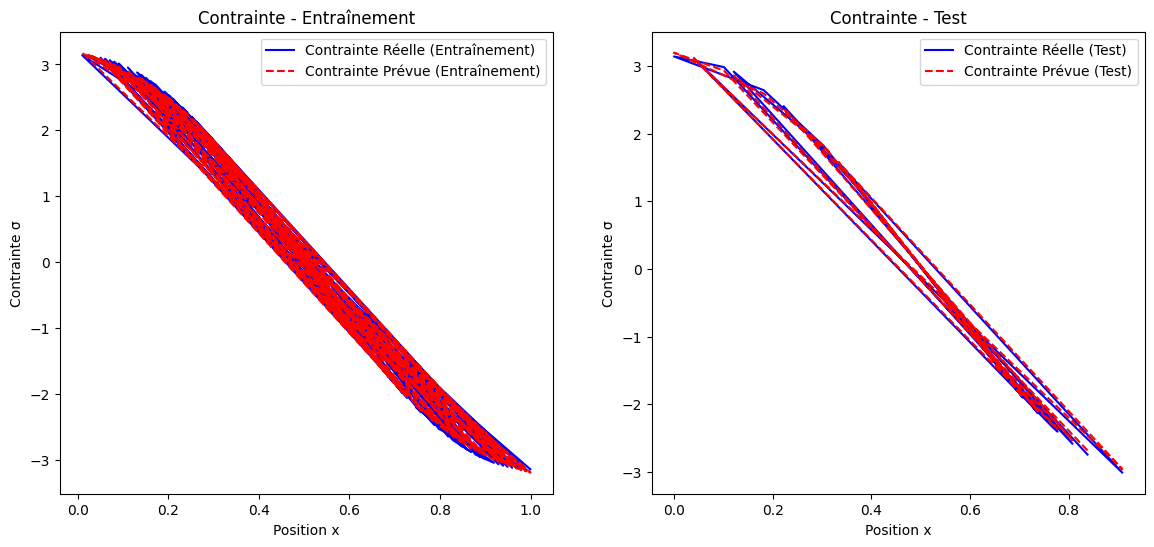

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Définir l'architecture du réseau avec plus de couches et de neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='tanh', input_shape=(1,)),  # Input shape corresponds to spatial dimension (1D here)
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(1)  # Output (stress σ)
])

# Générer des points d'entraînement
x = np.linspace(0, 1, 100)[:, None]  # 100 points dans la plage [0, 1]
σ = np.pi * np.cos(np.pi * x)  # Contraintes hypothétiques dérivées des déplacements

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, σ_train, σ_test = train_test_split(x, σ, test_size=0.2, random_state=42)

# Normaliser les données d'entrée en utilisant les statistiques de l'ensemble d'entraînement
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_train_norm = (x_train - x_train_mean) / x_train_std
x_test_norm = (x_test - x_train_mean) / x_train_std

# Convertir les données en tenseurs TensorFlow
x_train_tf = tf.convert_to_tensor(x_train_norm, dtype=tf.float32)
σ_train_tf = tf.convert_to_tensor(σ_train, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test_norm, dtype=tf.float32)
σ_test_tf = tf.convert_to_tensor(σ_test, dtype=tf.float32)

def compute_pde_loss(gradients):
    return tf.reduce_mean(tf.square(gradients))

def compute_bc_loss(predictions, bc_values):
    return tf.reduce_mean(tf.square(predictions - bc_values))

# Définir les valeurs de conditions aux limites
bc_values = np.array([0.0, 0.0], dtype=np.float32)  # Par exemple, zéro contrainte aux limites
bc_values_tf = tf.convert_to_tensor(bc_values, dtype=tf.float32)

# Sélectionner les points de la frontière dans l'ensemble d'entraînement
x_bc = tf.convert_to_tensor([x_train_norm[0], x_train_norm[-1]], dtype=tf.float32)
σ_bc = tf.convert_to_tensor([σ_train[0], σ_train[-1]], dtype=tf.float32)

def loss(model, x, σ_true):
    σ_pred = model(x)
    loss_data = tf.reduce_mean(tf.square(σ_true - σ_pred))
    
    # Calculer les gradients pour les PDEs
    with tf.GradientTape() as tape:
        tape.watch(x)
        σ_pred = model(x)
        gradients = tape.gradient(σ_pred, x)
    
    loss_pde = compute_pde_loss(gradients)
    
    # Appliquer les conditions aux limites uniquement aux points de la frontière
    σ_bc_pred = model(x_bc)
    loss_bc = compute_bc_loss(σ_bc_pred, σ_bc)
    
    return loss_data + 0.01 * loss_pde + 0.01 * loss_bc  # Pondération des termes de perte

# Optimiseur
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Entraînement
num_epochs = 1000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_train_tf, σ_train_tf)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
σ_pred_train = model(x_train_tf)
σ_pred_test = model(x_test_tf)

# Conversion des prédictions en numpy arrays pour la visualisation
σ_pred_train_np = σ_pred_train.numpy()
σ_pred_test_np = σ_pred_test.numpy()

# Visualisation des résultats
plt.figure(figsize=(14, 6))

# Plot des contraintes pour l'ensemble d'entraînement
plt.subplot(1, 2, 1)
plt.plot(x_train, σ_train, 'b-', label='Contrainte Réelle (Entraînement)')
plt.plot(x_train, σ_pred_train_np, 'r--', label='Contrainte Prévue (Entraînement)')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte - Entraînement')

# Plot des contraintes pour l'ensemble de test
plt.subplot(1, 2, 2)
plt.plot((x_test_norm * x_train_std) + x_train_mean, σ_test, 'b-', label='Contrainte Réelle (Test)')
plt.plot((x_test_norm * x_train_std) + x_train_mean, σ_pred_test_np, 'r--', label='Contrainte Prévue (Test)')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte - Test')

plt.show()


Epoch 0: Loss = 5.121307373046875
Epoch 100: Loss = 0.0741330087184906
Epoch 200: Loss = 0.06417904049158096
Epoch 300: Loss = 0.051141105592250824
Epoch 400: Loss = 0.04429414123296738
Epoch 500: Loss = 0.043318819254636765
Epoch 600: Loss = 0.04323996976017952
Epoch 700: Loss = 0.043194036930799484
Epoch 800: Loss = 0.04314936324954033
Epoch 900: Loss = 0.04310573637485504


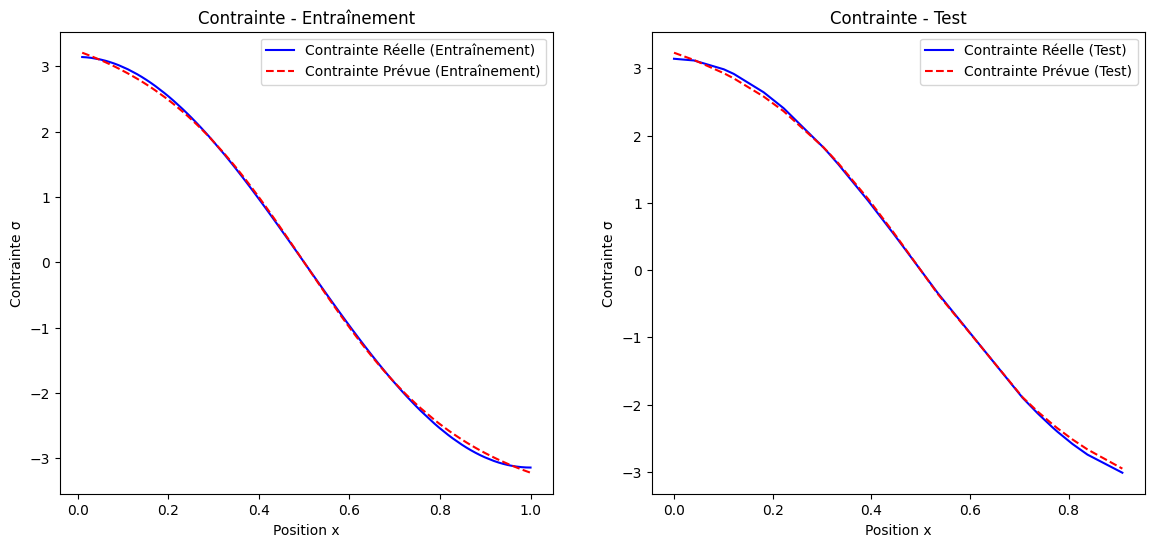

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Définir l'architecture du réseau avec initialisation des poids
initializer = tf.keras.initializers.GlorotNormal()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='tanh', input_shape=(1,), kernel_initializer=initializer),  # Input shape corresponds to spatial dimension (1D here)
    tf.keras.layers.Dense(200, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(200, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(200, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(1, kernel_initializer=initializer)  # Output (stress σ)
])

# Générer des points d'entraînement
x = np.linspace(0, 1, 100)[:, None]  # 100 points dans la plage [0, 1]
σ = np.pi * np.cos(np.pi * x)  # Contraintes hypothétiques dérivées des déplacements

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, σ_train, σ_test = train_test_split(x, σ, test_size=0.2, random_state=42)

# Normaliser les données d'entrée en utilisant les statistiques de l'ensemble d'entraînement
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_train_norm = (x_train - x_train_mean) / x_train_std
x_test_norm = (x_test - x_train_mean) / x_train_std

# Convertir les données en tenseurs TensorFlow
x_train_tf = tf.convert_to_tensor(x_train_norm, dtype=tf.float32)
σ_train_tf = tf.convert_to_tensor(σ_train, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test_norm, dtype=tf.float32)
σ_test_tf = tf.convert_to_tensor(σ_test, dtype=tf.float32)

def compute_pde_loss(gradients):
    return tf.reduce_mean(tf.square(gradients))

def compute_bc_loss(predictions, bc_values):
    return tf.reduce_mean(tf.square(predictions - bc_values))

# Définir les valeurs de conditions aux limites
bc_values = np.array([np.pi * np.cos(0), np.pi * np.cos(np.pi)], dtype=np.float32)  # Valeurs de contraintes aux limites (aux extrémités)
bc_values_tf = tf.convert_to_tensor(bc_values, dtype=tf.float32)

# Sélectionner les points de la frontière dans l'ensemble d'entraînement
x_bc = tf.convert_to_tensor([x_train_norm[0], x_train_norm[-1]], dtype=tf.float32)
σ_bc = tf.convert_to_tensor([σ_train[0], σ_train[-1]], dtype=tf.float32)

def loss(model, x, σ_true):
    σ_pred = model(x)
    loss_data = tf.reduce_mean(tf.square(σ_true - σ_pred))
    
    # Calculer les gradients pour les PDEs
    with tf.GradientTape() as tape:
        tape.watch(x)
        σ_pred = model(x)
        gradients = tape.gradient(σ_pred, x)
    
    loss_pde = compute_pde_loss(gradients)
    
    # Appliquer les conditions aux limites uniquement aux points de la frontière
    σ_bc_pred = model(x_bc)
    loss_bc = compute_bc_loss(σ_bc_pred, σ_bc)
    
    return loss_data + 0.01 * loss_pde + 0.01 * loss_bc  # Pondération des termes de perte

# Optimiseur
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Entraînement
num_epochs = 1000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_train_tf, σ_train_tf)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
σ_pred_train = model(x_train_tf)
σ_pred_test = model(x_test_tf)

# Conversion des prédictions en numpy arrays pour la visualisation
σ_pred_train_np = σ_pred_train.numpy()
σ_pred_test_np = σ_pred_test.numpy()

# Trier les données pour la visualisation
sorted_train_indices = np.argsort(x_train[:, 0])
sorted_test_indices = np.argsort(x_test[:, 0])

x_train_sorted = x_train[sorted_train_indices]
σ_train_sorted = σ_train[sorted_train_indices]
σ_pred_train_sorted = σ_pred_train_np[sorted_train_indices]

x_test_sorted = x_test[sorted_test_indices]
σ_test_sorted = σ_test[sorted_test_indices]
σ_pred_test_sorted = σ_pred_test_np[sorted_test_indices]

# Visualisation des résultats
plt.figure(figsize=(14, 6))

# Plot des contraintes pour l'ensemble d'entraînement
plt.subplot(1, 2, 1)
plt.plot(x_train_sorted, σ_train_sorted, 'b-', label='Contrainte Réelle (Entraînement)')
plt.plot(x_train_sorted, σ_pred_train_sorted, 'r--', label='Contrainte Prévue (Entraînement)')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte - Entraînement')

# Plot des contraintes pour l'ensemble de test
plt.subplot(1, 2, 2)
plt.plot(x_test_sorted, σ_test_sorted, 'b-', label='Contrainte Réelle (Test)')
plt.plot(x_test_sorted, σ_pred_test_sorted, 'r--', label='Contrainte Prévue (Test)')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte - Test')

plt.show()


Epoch 0: Loss = 5.201991558074951
Epoch 1000: Loss = 0.03210587799549103


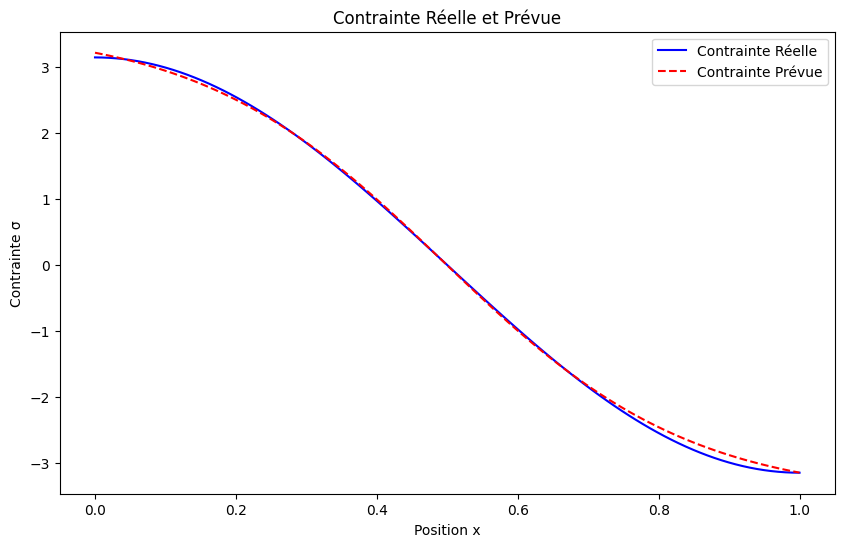

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Définir l'architecture du réseau avec initialisation des poids
initializer = tf.keras.initializers.GlorotNormal()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='tanh', input_shape=(1,), kernel_initializer=initializer),  # Input shape corresponds to spatial dimension (1D here)
    tf.keras.layers.Dense(200, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(200, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(200, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(1, kernel_initializer=initializer)  # Output (stress σ)
])

# Générer des points d'entraînement
x = np.linspace(0, 1, 100)[:, None]  # 100 points dans la plage [0, 1]
σ = np.pi * np.cos(np.pi * x)  # Contraintes hypothétiques dérivées des déplacements

# Trier les données avant la division
sorted_indices = np.argsort(x[:, 0])
x_sorted = x[sorted_indices]
σ_sorted = σ[sorted_indices]

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
split_index = int(0.8 * len(x_sorted))
x_train, x_test = x_sorted[:split_index], x_sorted[split_index:]
σ_train, σ_test = σ_sorted[:split_index], σ_sorted[split_index:]

# Normaliser les données d'entrée en utilisant les statistiques de l'ensemble d'entraînement
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_train_norm = (x_train - x_train_mean) / x_train_std
x_test_norm = (x_test - x_train_mean) / x_train_std

# Convertir les données en tenseurs TensorFlow
x_train_tf = tf.convert_to_tensor(x_train_norm, dtype=tf.float32)
σ_train_tf = tf.convert_to_tensor(σ_train, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test_norm, dtype=tf.float32)
σ_test_tf = tf.convert_to_tensor(σ_test, dtype=tf.float32)

def compute_pde_loss(gradients):
    return tf.reduce_mean(tf.square(gradients))

def compute_bc_loss(predictions, bc_values):
    return tf.reduce_mean(tf.square(predictions - bc_values))

# Définir les valeurs de conditions aux limites
bc_values = np.array([np.pi * np.cos(0), np.pi * np.cos(np.pi)], dtype=np.float32)  # Valeurs de contraintes aux limites (aux extrémités)
bc_values_tf = tf.convert_to_tensor(bc_values, dtype=tf.float32)

# Sélectionner les points de la frontière dans l'ensemble d'entraînement
x_bc = tf.convert_to_tensor([x_train_norm[0], x_train_norm[-1]], dtype=tf.float32)
σ_bc = tf.convert_to_tensor([σ_train[0], σ_train[-1]], dtype=tf.float32)

def loss(model, x, σ_true):
    σ_pred = model(x)
    loss_data = tf.reduce_mean(tf.square(σ_true - σ_pred))
    
    # Calculer les gradients pour les PDEs
    with tf.GradientTape() as tape:
        tape.watch(x)
        σ_pred = model(x)
        gradients = tape.gradient(σ_pred, x)
    
    loss_pde = compute_pde_loss(gradients)
    
    # Appliquer les conditions aux limites uniquement aux points de la frontière
    σ_bc_pred = model(x_bc)
    loss_bc = compute_bc_loss(σ_bc_pred, σ_bc)
    
    return loss_data + 0.01 * loss_pde + 0.01 * loss_bc  # Pondération des termes de perte

# Optimiseur
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Entraînement
num_epochs = 2000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x_train_tf, σ_train_tf)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
σ_pred_train = model(x_train_tf)
σ_pred_test = model(x_test_tf)

# Conversion des prédictions en numpy arrays pour la visualisation
σ_pred_train_np = σ_pred_train.numpy()
σ_pred_test_np = σ_pred_test.numpy()

# Combine training and test data for visualization
x_combined = np.concatenate((x_train, x_test), axis=0)
σ_combined = np.concatenate((σ_train, σ_test), axis=0)
σ_pred_combined = np.concatenate((σ_pred_train_np, σ_pred_test_np), axis=0)

# Sort combined data for proper plotting
sorted_combined_indices = np.argsort(x_combined[:, 0])
x_combined_sorted = x_combined[sorted_combined_indices]
σ_combined_sorted = σ_combined[sorted_combined_indices]
σ_pred_combined_sorted = σ_pred_combined[sorted_combined_indices]

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(x_combined_sorted, σ_combined_sorted, 'b-', label='Contrainte Réelle')
plt.plot(x_combined_sorted, σ_pred_combined_sorted, 'r--', label='Contrainte Prévue')
plt.xlabel('Position x')
plt.ylabel('Contrainte σ')
plt.legend()
plt.title('Contrainte Réelle et Prévue')
plt.show()


<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:87: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:87: SyntaxWarning: invalid escape sequence '\s'
C:\Users\TOUGERON\AppData\Local\Temp\ipykernel_22900\729170616.py:71: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Contrainte $\sigma_{xx}$ prédite')
C:\Users\TOUGERON\AppData\Local\Temp\ipykernel_22900\729170616.py:79: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Contrainte $\sigma_{yy}$ prédite')
C:\Users\TOUGERON\AppData\Local\Temp\ipykernel_22900\729170616.py:87: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Contrainte $\sigma_{xy}$ prédite')


Epoch 0: Loss = 285087715295232.0
Epoch 1000: Loss = 285086708662272.0
Epoch 2000: Loss = 285085836247040.0
Epoch 3000: Loss = 285084997386240.0
Epoch 4000: Loss = 285084124971008.0
Epoch 5000: Loss = 285083319664640.0
Epoch 6000: Loss = 285082447249408.0
Epoch 7000: Loss = 285081641943040.0
Epoch 8000: Loss = 285080735973376.0
Epoch 9000: Loss = 285079897112576.0


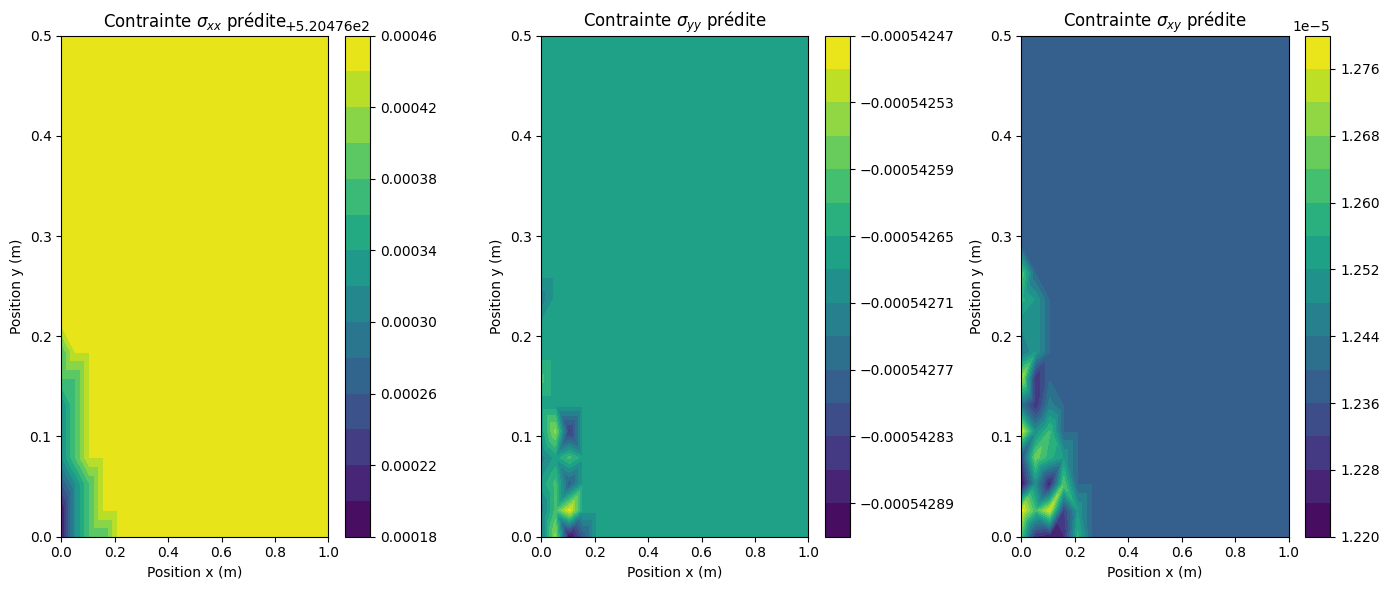

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Paramètres physiques
E = 210e9  # Module de Young en Pa (210 GPa)
nu = 0.3   # Coefficient de Poisson
sigma_applied = 50e6  # Contrainte appliquée en Pa (50 MPa)

# Générer des points de données (20 points de contrainte connus)
# On considère une plaque de longueur 1 m et de hauteur 0.5 m
x = np.linspace(0, 1, 20)
y = np.linspace(0, 0.5, 20)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()

# Contrainte connue (exemple simplifié avec une distribution linéaire pour illustration)
sigma_xx_known = sigma_applied * xx / 1.0  # Distribution linéaire simplifiée
sigma_yy_known = np.zeros_like(sigma_xx_known)  # Pour simplification
sigma_xy_known = np.zeros_like(sigma_xx_known)  # Pour simplification

# Convertir les données en tenseurs TensorFlow
xy_train = tf.convert_to_tensor(np.vstack([xx, yy]).T, dtype=tf.float32)
sigma_train = tf.convert_to_tensor(np.vstack([sigma_xx_known, sigma_yy_known, sigma_xy_known]).T, dtype=tf.float32)

# Définir le modèle PINN
initializer = tf.keras.initializers.GlorotNormal()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='tanh', input_shape=(2,), kernel_initializer=initializer),
    tf.keras.layers.Dense(50, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(50, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(50, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(3, kernel_initializer=initializer)  # Outputs: sigma_xx, sigma_yy, sigma_xy
])

# Fonction de perte
def loss(model, xy, sigma_true):
    sigma_pred = model(xy)
    loss_data = tf.reduce_mean(tf.square(sigma_true - sigma_pred))
    return loss_data

# Optimiseur
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Entraînement
num_epochs = 10000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, xy_train, sigma_train)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
xy_test = np.vstack([xx, yy]).T
xy_test_tf = tf.convert_to_tensor(xy_test, dtype=tf.float32)
sigma_pred = model(xy_test_tf)
sigma_pred_np = sigma_pred.numpy()

# Visualisation des résultats
plt.figure(figsize=(14, 6))

# Contrainte sigma_xx
plt.subplot(1, 3, 1)
plt.tricontourf(xx, yy, sigma_pred_np[:, 0], levels=14, cmap="viridis")
plt.colorbar()
plt.title('Contrainte $\sigma_{xx}$ prédite')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')

# Contrainte sigma_yy
plt.subplot(1, 3, 2)
plt.tricontourf(xx, yy, sigma_pred_np[:, 1], levels=14, cmap="viridis")
plt.colorbar()
plt.title('Contrainte $\sigma_{yy}$ prédite')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')

# Contrainte sigma_xy
plt.subplot(1, 3, 3)
plt.tricontourf(xx, yy, sigma_pred_np[:, 2], levels=14, cmap="viridis")
plt.colorbar()
plt.title('Contrainte $\sigma_{xy}$ prédite')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')

plt.tight_layout()
plt.show()


<>:102: SyntaxWarning: invalid escape sequence '\s'
<>:110: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\s'
<>:110: SyntaxWarning: invalid escape sequence '\s'
C:\Users\TOUGERON\AppData\Local\Temp\ipykernel_22900\1046654112.py:102: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Contrainte $\sigma_{xx}$ réelle')
C:\Users\TOUGERON\AppData\Local\Temp\ipykernel_22900\1046654112.py:110: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Contrainte $\sigma_{xx}$ prédite')


Epoch 0: Loss = 855263078776832.0
Epoch 100: Loss = 855213552435200.0
Epoch 200: Loss = 854878276550656.0
Epoch 300: Loss = 853927545274368.0
Epoch 400: Loss = 852046886469632.0
Epoch 500: Loss = 848957932568576.0
Epoch 600: Loss = 844422245777408.0
Epoch 700: Loss = 838241452294144.0
Epoch 800: Loss = 830257913397248.0
Epoch 900: Loss = 820354188574720.0


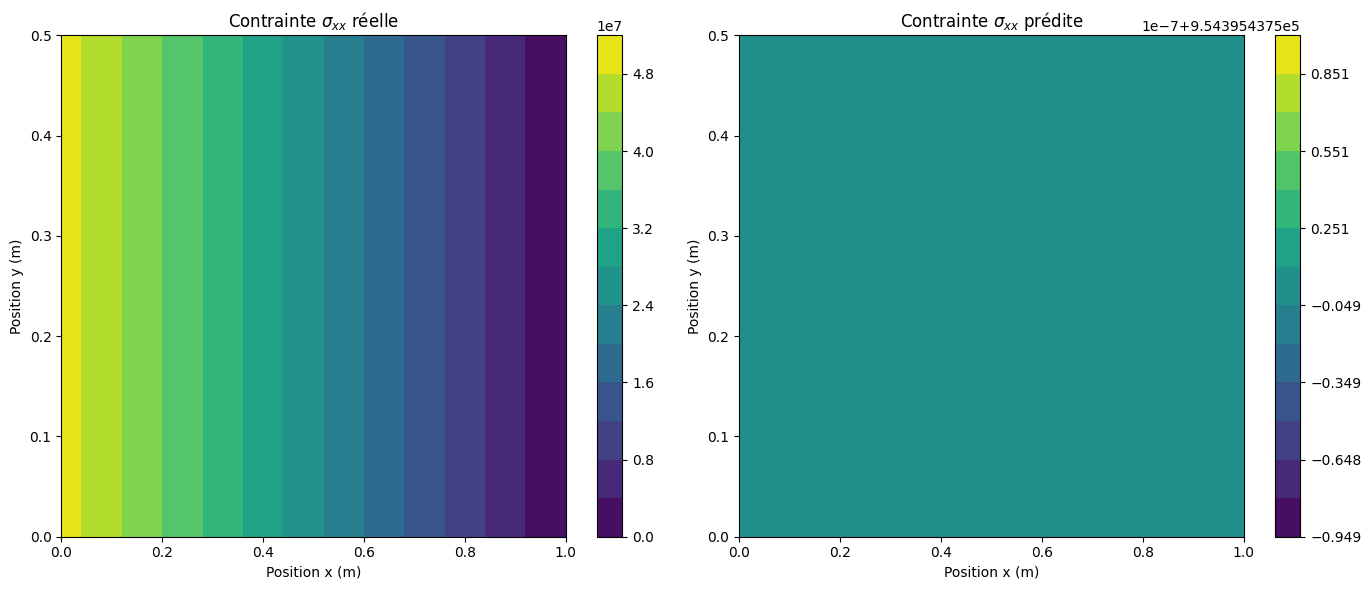

In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Paramètres physiques
E = 210e9  # Module de Young en Pa (210 GPa)
nu = 0.3   # Coefficient de Poisson
sigma_applied = 50e6  # Contrainte appliquée en Pa (50 MPa)
Lx = 1.0  # Longueur de la plaque en m
Ly = 0.5  # Hauteur de la plaque en m

# Fonction analytique pour sigma_xx
def analytical_sigma_xx(x, y, Lx, Ly, sigma_applied):
    return sigma_applied * (1 - x / Lx)

# Générer des points de maillage pour calculer les contraintes
x = np.linspace(0, Lx, 20)
y = np.linspace(0, Ly, 20)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()

# Calculer les contraintes réelles
sigma_xx_real = analytical_sigma_xx(xx, yy, Lx, Ly, sigma_applied)

# Convertir les données en tenseurs TensorFlow
xy_train = tf.convert_to_tensor(np.vstack([xx, yy]).T, dtype=tf.float32)
sigma_xx_train = tf.convert_to_tensor(sigma_xx_real[:, None], dtype=tf.float32)

# Générer des points pour imposer les lois de la physique (maillage)
x_phys = np.linspace(0, Lx, 50)
y_phys = np.linspace(0, Ly, 50)
xx_phys, yy_phys = np.meshgrid(x_phys, y_phys)
xx_phys = xx_phys.flatten()
yy_phys = yy_phys.flatten()
xy_phys = tf.convert_to_tensor(np.vstack([xx_phys, yy_phys]).T, dtype=tf.float32)

# Définir le modèle PINN
initializer = tf.keras.initializers.GlorotNormal()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='tanh', input_shape=(2,), kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation='linear', kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation='tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation='linear', kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation='linear', kernel_initializer=initializer),
    tf.keras.layers.Dense(1, kernel_initializer=initializer)  # Output: sigma_xx
])

# Fonction de perte
def loss(model, xy_train, sigma_xx_train, xy_phys):
    sigma_xx_pred = model(xy_train)
    loss_data = tf.reduce_mean(tf.square(sigma_xx_train - sigma_xx_pred))
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xy_phys)
        sigma_xx_pred_phys = model(xy_phys)
        
        grad_sigma_xx = tape.gradient(sigma_xx_pred_phys, xy_phys)
        
    grad_sigma_xx_x = grad_sigma_xx[:, 0]
    
    eq1 = grad_sigma_xx_x
    
    loss_phys = tf.reduce_mean(tf.square(eq1))
    
    return loss_data + loss_phys

# Optimiseur
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Entraînement
num_epochs = 1000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, xy_train, sigma_xx_train, xy_phys)
    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

# Prédictions après l'entraînement
xy_test = np.vstack([xx_phys, yy_phys]).T
xy_test_tf = tf.convert_to_tensor(xy_test, dtype=tf.float32)
sigma_xx_pred = model(xy_test_tf)
sigma_xx_pred_np = sigma_xx_pred.numpy()

# Calculer les contraintes réelles pour les points de test
sigma_xx_real_test = analytical_sigma_xx(xx_phys, yy_phys, Lx, Ly, sigma_applied)

# Visualisation des résultats
plt.figure(figsize=(14, 6))

# Contrainte sigma_xx réelle
plt.subplot(1, 2, 1)
plt.tricontourf(xx_phys, yy_phys, sigma_xx_real_test, levels=14, cmap="viridis")
plt.colorbar()
plt.title('Contrainte $\sigma_{xx}$ réelle')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')

# Contrainte sigma_xx prédite
plt.subplot(1, 2, 2)
plt.tricontourf(xx_phys, yy_phys, sigma_xx_pred_np.flatten(), levels=14, cmap="viridis")
plt.colorbar()
plt.title('Contrainte $\sigma_{xx}$ prédite')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')

plt.tight_layout()
plt.show()
